In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import matplotlib.pyplot as plt
!pip install pmdarima
from pmdarima import auto_arima
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from sklearn.linear_model import LinearRegression


In [2]:
data=pd.read_csv("Book1.csv")
data.rename(columns = {'sales':'ticket_count'}, inplace = True)
data

,date,ticket_count
0,2018-01-01,884
1,2018-02-01,920
2,2018-03-01,965
3,2018-04-01,987
4,2018-05-01,996
5,2018-06-01,997
6,2018-07-01,1543
7,2018-08-01,1434
8,2018-09-01,987
9,2018-10-01,934


In [3]:
warnings.filterwarnings("ignore")

In [4]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date').asfreq('D')

In [5]:
data =data.dropna()

In [6]:
def arima_sarima(data):
    rmse_error=0
    result = seasonal_decompose(data['ticket_count'],model ='multiplicative',period=1)
    stepwise_fit = auto_arima(data['ticket_count'], start_p = 1, start_q = 1,max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True) 
    train = data.iloc[:len(data)-12]
    test = data.iloc[len(data)-12:] 
    model = SARIMAX(train['ticket_count'], 
                order = (1,0,0), 
                seasonal_order =(0, 1, 0, 12))
    result = model.fit()
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = result.predict(start, end,typ = 'levels').rename("Predictions")
    rmse_error=rmse(test["ticket_count"], predictions)
    mse=mean_squared_error(test["ticket_count"], predictions)
    return rmse_error

In [7]:
def lstm(data):
    results = seasonal_decompose(data['ticket_count'])
    train = data.iloc[:48]
    test = data.iloc[48:]
    test1=test.copy()
    scaler = MinMaxScaler()
    scaler.fit(train)
    scaled_train = scaler.transform(train)
    scaled_test = scaler.transform(test)
    scaled_train[:10]
    n_input = 3
    n_features = 1
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
    X,y = generator[0]
    n_input = 12
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(generator,epochs=50)
    loss_per_epoch = model.history.history['loss']
    last_train_batch = scaled_train[-12:]
    last_train_batch = last_train_batch.reshape((1, n_input, n_features))
    model.predict(last_train_batch)
    test_predictions = []

    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))
    for i in range(len(test)):
        current_pred = model.predict(current_batch)[0]
        test_predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    true_predictions = scaler.inverse_transform(test_predictions)
    test['Predictions'] = true_predictions
    rmse=sqrt(mean_squared_error(test1['ticket_count'],test['Predictions']))
    return rmse

In [8]:
x=arima_sarima(data)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=674.783, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=675.030, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=673.406, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=674.513, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=695.488, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=672.431, Time=0.02 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=673.396, Time=0.11 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=675.413, Time=0.17 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=673.781, Time=0.06 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=673.686, Time=0.09 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=673.272, Time=0.04 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=675.610, Time=0.13 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=678.958, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 1.402 seconds


In [9]:
y=lstm(data)

Epoch 1/50
36/36 [==============================] - 1s 3ms/step - loss: 0.0769
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0587
Epoch 3/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0511
Epoch 4/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0483
Epoch 5/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0458
Epoch 6/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.0438
Epoch 8/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0423
Epoch 9/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0397
Epoch 10/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0343
Epoch 11/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0382
Epoch 12/50
36/36 [==============================] - 0s 3ms/step - loss: 0.0497
Epoch 13/50
36/36 [==============================

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
data['Time'] = np.arange(len(data.index))
def linear_reg(data):
    def lin_reg(X,y):
        model = LinearRegression()
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index=X.index)
        return y_pred
    X = data.loc[:, ['Time']]  
    y = data.loc[:, 'ticket_count'] 
    y_predi=lin_reg(X,y)
    data["predicted"]=y_predi
    return np.sqrt(mean_squared_error(y, y_predi))

In [11]:
k=linear_reg(data)

rmse of arima-sarima prediction is: 164.15575968167173
rmse of lstm prediction is: 277547.9537177841
rmse of Linear regression prediction is: 421.9485624848219
the best model fit is arima-sarima:


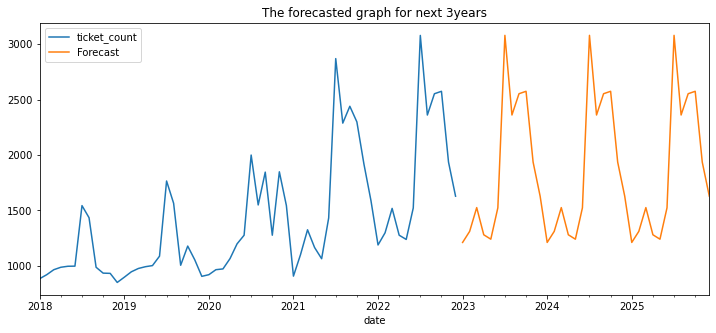

In [12]:
print('rmse of arima-sarima prediction is:',x)
print('rmse of lstm prediction is:',y)
print('rmse of Linear regression prediction is:',k)
if(x<y):
    print('the best model fit is arima-sarima:')
    model = model = SARIMAX(data['ticket_count'], 
                        order = (1, 0,0), 
                        seasonal_order =(0, 1, 0, 12))
    result = model.fit()
    forecast = result.predict(start = len(data), 
                          end = (len(data)-1) + 3 * 12, 
                          typ = 'levels').rename('Forecast')
    data['ticket_count'].plot(figsize = (12, 5), legend = True)
    plt.title('The forecasted graph for next 3years')
    forecast.plot(legend = True)

In [13]:
forecast

2023-01-01    1210.826013
2023-02-01    1310.707972
2023-03-01    1525.074935
2023-04-01    1279.938843
2023-05-01    1240.192880
2023-06-01    1523.220847
2023-07-01    3078.679684
2023-08-01    2360.378402
2023-09-01    2552.210669
2023-10-01    2574.117286
2023-11-01    1936.065297
2023-12-01    1628.036353
2024-01-01    1210.846252
2024-02-01    1310.719240
2024-03-01    1525.081208
2024-04-01    1279.942335
2024-05-01    1240.194824
2024-06-01    1523.221929
2024-07-01    3078.680287
2024-08-01    2360.378738
2024-09-01    2552.210855
2024-10-01    2574.117390
2024-11-01    1936.065355
2024-12-01    1628.036385
2025-01-01    1210.846270
2025-02-01    1310.719250
2025-03-01    1525.081214
2025-04-01    1279.942339
2025-05-01    1240.194826
2025-06-01    1523.221930
2025-07-01    3078.680288
2025-08-01    2360.378738
2025-09-01    2552.210856
2025-10-01    2574.117390
2025-11-01    1936.065355
2025-12-01    1628.036385
Freq: MS, Name: Forecast, dtype: float64